In [1]:
import pickle

from gym.wrappers import FilterObservation, FlattenObservation, FrameStack, RecordVideo, RescaleAction, TimeLimit
import matplotlib.pyplot as plt
import numpy as np
from stable_baselines3 import A2C, PPO
from stable_baselines3.common.env_util import unwrap_wrapper
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.vec_env import DummyVecEnv, VecNormalize

from environment import ARESEA
from utils import FilterAction, RecordData

In [16]:
# with open("models/jedi-carrier-139/misalignments.pkl", "rb") as f:
#     misalignments = pickle.load(f)
# with open("models/jedi-carrier-139/incoming_parameters.pkl", "rb") as f:
#     incoming_parameters = pickle.load(f)

def make_env():
    # env = ARESEA(misalignments=misalignments, incoming_parameters=incoming_parameters)
    env = ARESEA()
    env = FilterObservation(env, ["beam","magnets"])
    env = FilterAction(env, [0,1,3], replace=0)
    env = TimeLimit(env, max_episode_steps=50)
    env = RecordVideo(env, video_folder="recordings")
    env = RecordData(env)
    env = FlattenObservation(env)
    env = FrameStack(env, 4)
    env = RescaleAction(env, -3, 3)
    env = Monitor(env)
    return env

env = DummyVecEnv([make_env])
# env = VecNormalize.load("model_env.pkl", env)
env.training = False

model = PPO.load("models/jedi-carrier-139/model")

/usr/local/Caskroom/miniconda/base/envs/rl39/lib/python3.9/site-packages/gym/wrappers/record_video.py:41: UserWarning: WARN: Overwriting existing videos at /Users/jankaiser/Documents/DESY/ares-ea-rl/recordings folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


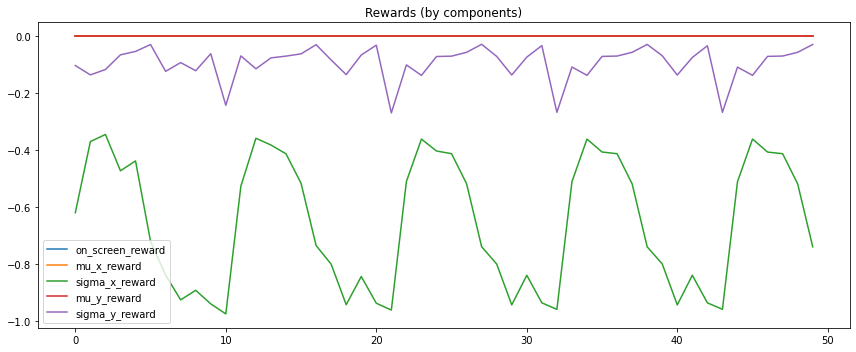

In [17]:
observation = env.reset()
done = False
while not done:
    action, _ = model.predict(observation, deterministic=True)
    observation, reward, done, info = env.step(action)

infos = unwrap_wrapper(env.envs[0], RecordData).previous_infos

# time_reward = [info["time_reward"] for info in infos]
on_screen_reward = [info["on_screen_reward"] for info in infos]
mu_x_reward = [info["mu_x_reward"] for info in infos]
sigma_x_reward = [info["sigma_x_reward"] for info in infos]
mu_y_reward = [info["mu_y_reward"] for info in infos]
sigma_y_reward = [info["sigma_y_reward"] for info in infos]
# aspect_ratio_reward = [info["aspect_ratio_reward"] for info in infos]

plt.figure(figsize=(12,5))
plt.title("Rewards (by components)")
# plt.plot(time_reward, label="time_reward")
plt.plot(on_screen_reward, label="on_screen_reward")
plt.plot(mu_x_reward, label="mu_x_reward")
plt.plot(sigma_x_reward, label="sigma_x_reward")
plt.plot(mu_y_reward, label="mu_y_reward")
plt.plot(sigma_y_reward, label="sigma_y_reward")
# plt.plot(aspect_ratio_reward, label="aspect_ratio_reward")
plt.legend()
plt.tight_layout()
plt.show()

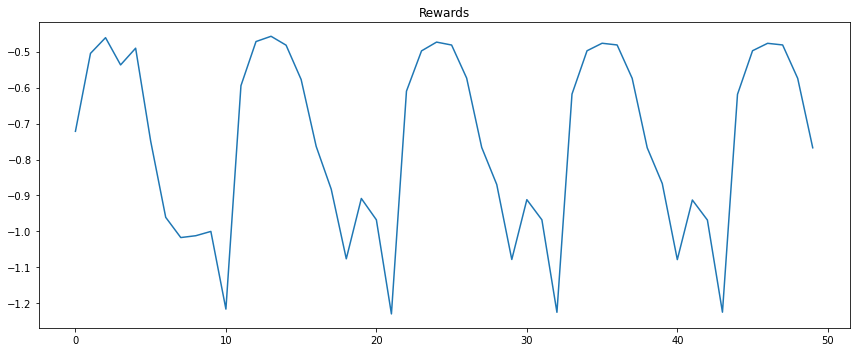

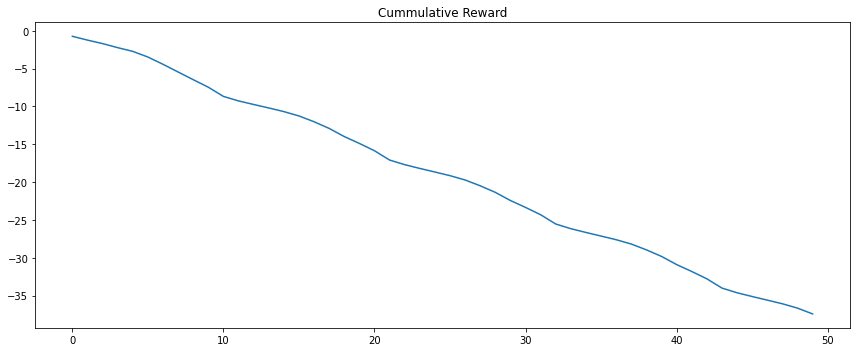

In [18]:
plt.figure(figsize=(12,5))
plt.title("Rewards")
plt.plot(unwrap_wrapper(env.envs[0], RecordData).previous_rewards)
plt.tight_layout()
plt.show()

plt.figure(figsize=(12,5))
plt.title("Cummulative Reward")
plt.plot(np.cumsum(unwrap_wrapper(env.envs[0], RecordData).previous_rewards))
plt.tight_layout()
plt.show()

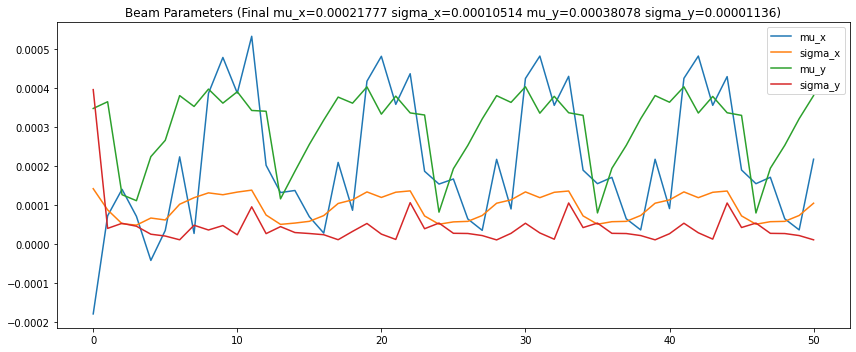

In [19]:
observations = unwrap_wrapper(env.envs[0], RecordData).previous_observations

mu_x = [observation["beam"][0] for observation in observations]
sigma_x = [observation["beam"][1] for observation in observations]
mu_y = [observation["beam"][2] for observation in observations]
sigma_y = [observation["beam"][3] for observation in observations]

plt.figure(figsize=(12,5))
plt.title(f"Beam Parameters (Final mu_x={mu_x[-1]:.8f} sigma_x={sigma_x[-1]:.8f} mu_y={mu_y[-1]:.8f} sigma_y={sigma_y[-1]:.8f})")
plt.plot(mu_x, label="mu_x")
plt.plot(sigma_x, label="sigma_x")
plt.plot(mu_y, label="mu_y")
plt.plot(sigma_y, label="sigma_y")
plt.legend()
plt.tight_layout()
plt.show()

q1[-1]=2.7052002 / q2[-1]=6.5580215 / q3[-1]=-17.846771


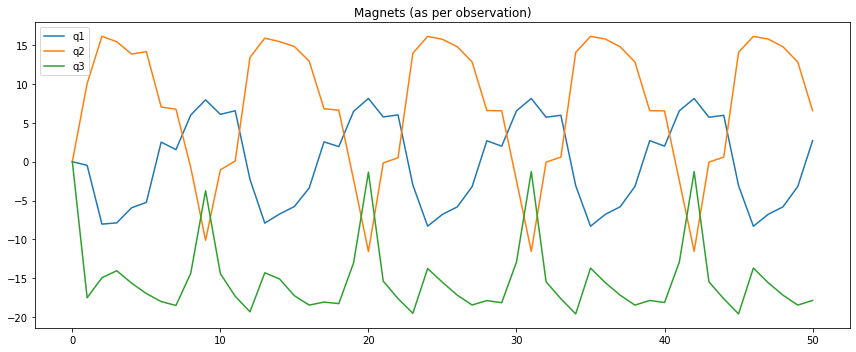

In [20]:
observations = unwrap_wrapper(env.envs[0], RecordData).previous_observations

q1 = [observation["magnets"][0] for observation in observations]
q2 = [observation["magnets"][1] for observation in observations]
cv = [observation["magnets"][2] for observation in observations]
q3 = [observation["magnets"][3] for observation in observations]
ch = [observation["magnets"][4] for observation in observations]

print(f"{q1[-1]=} / {q2[-1]=} / {q3[-1]=}")

plt.figure(figsize=(12,5))
plt.title("Magnets (as per observation)")
plt.plot(q1, label="q1")
plt.plot(q2, label="q2")
# plt.plot(cv, label="cv")
plt.plot(q3, label="q3")
# plt.plot(ch, label="ch")
plt.legend()
plt.tight_layout()
plt.show()

q1[-1]=2.7052002 / q2[-1]=6.5580215 / q3[-1]=-17.846771


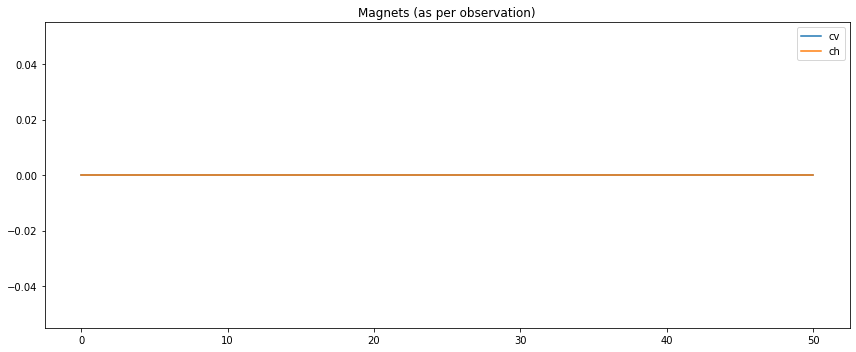

In [21]:
observations = unwrap_wrapper(env.envs[0], RecordData).previous_observations

q1 = [observation["magnets"][0] for observation in observations]
q2 = [observation["magnets"][1] for observation in observations]
cv = [observation["magnets"][2] for observation in observations]
q3 = [observation["magnets"][3] for observation in observations]
ch = [observation["magnets"][4] for observation in observations]

print(f"{q1[-1]=} / {q2[-1]=} / {q3[-1]=}")

plt.figure(figsize=(12,5))
plt.title("Magnets (as per observation)")
# plt.plot(q1, label="q1")
# plt.plot(q2, label="q2")
plt.plot(cv, label="cv")
# plt.plot(q3, label="q3")
plt.plot(ch, label="ch")
plt.legend()
plt.tight_layout()
plt.show()

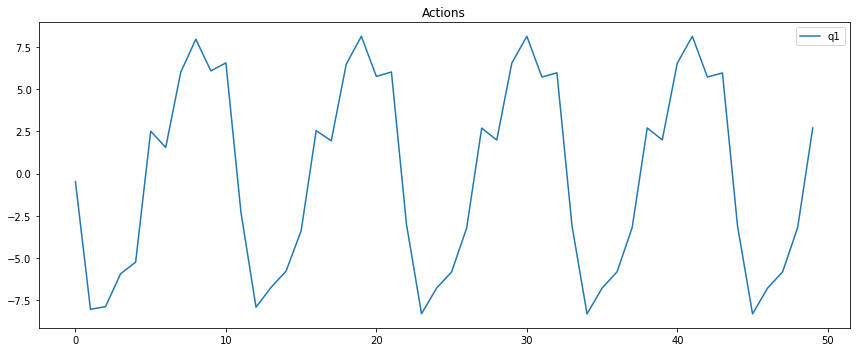

In [22]:
actions = unwrap_wrapper(env.envs[0], RecordData).previous_actions

q1 = [action[0] for action in actions]
# q3 = [action[0] for action in actions]
# cv = [action[0] for action in actions]
# ch = [action[1] for action in actions]

plt.figure(figsize=(12,5))
plt.title("Actions")
plt.plot(q1, label="q1")
# plt.plot(cv, label="cv")
# plt.plot(q3, label="q3")
# plt.plot(ch, label="ch")
plt.legend()
plt.tight_layout()
plt.show()